In [19]:
import pandas as pd
import geopandas as gpd
import cbsodata
import numpy as np
import matplotlib.pyplot as plt

In [20]:
data_nl = pd.DataFrame(cbsodata.get_meta('85826NED', 'TypedDataSet'))

data_nl = data_nl[['ID', 'Persoonskenmerken', 'RegioS','Perioden','WerklozeBeroepsbevolking_12']]

data_nl = data_nl[data_nl['Perioden'] == '2020JJ00']
data_nl['Perioden'] = data_nl['Perioden'].str.extract(r'(\d{4})')

data_nl = data_nl[data_nl['Persoonskenmerken'] == 'T009002']

#data_nl.replace(0, np.nan, inplace=True)
data_nl = data_nl.dropna()

data_nl


,ID,Persoonskenmerken,RegioS,Perioden,WerklozeBeroepsbevolking_12
7,7,T009002,NL01,2020,465.0
18,18,T009002,LD01,2020,47.0
29,29,T009002,LD02,2020,92.0
40,40,T009002,LD03,2020,232.0
51,51,T009002,LD04,2020,94.0
...,...,...,...,...,...
4726,4726,T009002,AM34,2020,9.0
4737,4737,T009002,AM35,2020,3.0
4748,4748,T009002,AM36,2020,13.0
4759,4759,T009002,AM37,2020,10.0


In [21]:
data_de = pd.read_csv("out/csvs/indicator_Arbeitslose.csv")

data_de = data_de[data_de['Zeitbezug'] == 2020]

data_de['Wert'] = data_de['Wert'] / 1000

#data_de.replace(0, np.nan, inplace=True)
data_de = data_de.dropna()

data_de

,Kennziffer,Wert,Zeitbezug
25,111,2695.456,2020
51,1,92.140,2020
77,2,80.677,2020
103,3,251.377,2020
129,4,40.823,2020
...,...,...,...
116428,16073000,3.111,2020
116454,16074000,1.984,2020
116480,16075000,2.090,2020
116506,16076000,2.590,2020


In [34]:
municipal_boundaries_nl = gpd.read_file(filename='GeoJSON:https://service.pdok.nl/cbs/gebiedsindelingen/2021/wfs/v1_0?request=GetFeature&service=WFS&version=1.1.0&outputFormat=json&typeName=gebiedsindelingen:gemeente_gegeneraliseerd', engine="pyogrio")

municipal_boundaries_nl = municipal_boundaries_nl[['statcode', 'statnaam', 'geometry']]

municipal_boundaries_nl = pd.merge(municipal_boundaries_nl, data_nl,
                               left_on = "statcode", 
                               right_on = "RegioS")

municipal_boundaries_nl = municipal_boundaries_nl[['statcode', 'statnaam', 'geometry', 'RegioS', 'WerklozeBeroepsbevolking_12', 'Perioden' ]]

municipal_boundaries_nl.columns = ['Code', 'Name', 'geometry', 'Kennziffer', 'Wert', 'Zeitbezug']

print(municipal_boundaries_nl['Name'].is_unique)

municipal_boundaries_nl


True


,Code,Name,geometry,Kennziffer,Wert,Zeitbezug
0,GM0014,Groningen,"MULTIPOLYGON (((245194.691 592594.007, 245344....",GM0014,9.0,2020
1,GM0034,Almere,"MULTIPOLYGON (((146891.056 493291.709, 147422....",GM0034,7.0,2020
2,GM0037,Stadskanaal,"MULTIPOLYGON (((263763.866 566430.392, 263988....",GM0037,1.0,2020
3,GM0047,Veendam,"MULTIPOLYGON (((256231.909 572319.213, 258595....",GM0047,1.0,2020
4,GM0050,Zeewolde,"MULTIPOLYGON (((170596.293 486786.456, 170560....",GM0050,1.0,2020
...,...,...,...,...,...,...
333,GM1966,Het Hogeland,"MULTIPOLYGON (((215071.742 595253.084, 215169....",GM1966,1.0,2020
334,GM1969,Westerkwartier,"MULTIPOLYGON (((217623.770 592502.490, 217917....",GM1969,1.0,2020
335,GM1970,Noardeast-Fryslân,"MULTIPOLYGON (((207686.537 595425.623, 207640....",GM1970,1.0,2020
336,GM1978,Molenlanden,"MULTIPOLYGON (((123712.581 439998.364, 124188....",GM1978,1.0,2020


In [51]:
municipal_boundaries_de = gpd.read_file(filename='../data/DE_VG250.gpkg', layer="vg250_krs",engine="pyogrio")

municipal_boundaries_de['AGS_int'] = municipal_boundaries_de.AGS_0.astype(int)

municipal_boundaries_de = municipal_boundaries_de[municipal_boundaries_de['GF'] == 4]

municipal_boundaries_de = municipal_boundaries_de[municipal_boundaries_de['BEZ'] == 'Landkreis']


municipal_boundaries_de = municipal_boundaries_de[['AGS_int', 'GEN', 'geometry']]

municipal_boundaries_de = pd.merge(municipal_boundaries_de, data_de,
                             left_on = "AGS_int", 
                              right_on = "Kennziffer")

municipal_boundaries_de.columns = ['Code', 'Name', 'geometry', 'Kennziffer', 'Wert', 'Zeitbezug']

# Doppelte Werte in der Spalte finden
doppelte_werte_serie = municipal_boundaries_de.duplicated(subset=['Name'], keep=False)
indexe_doppelter_werte = municipal_boundaries_de[doppelte_werte_serie].index


# Doppelte Werte in der Spalte abrufen
doppelte_werte = municipal_boundaries_de.loc[doppelte_werte_serie, 'Name'].unique()

print("\nDoppelte Werte in der Spalte:")
print(doppelte_werte)
print("\nIndexe der Zeilen mit doppelten Werten in der Spalte:")
print(indexe_doppelter_werte)

print(municipal_boundaries_de['Name'].is_unique)

municipal_boundaries_de

#municipal_boundaries_de


Doppelte Werte in der Spalte:
[]

Indexe der Zeilen mit doppelten Werten in der Spalte:
Index([], dtype='int64')
True


,Code,Name,geometry,Kennziffer,Wert,Zeitbezug
0,3151000,Gifhorn,"MULTIPOLYGON (((605082.647 5854329.498, 605424...",3151000,4.279,2020
1,3153000,Goslar,"MULTIPOLYGON (((599997.323 5767773.893, 600061...",3153000,4.756,2020
2,3154000,Helmstedt,"MULTIPOLYGON (((631378.458 5814066.892, 631701...",3154000,3.096,2020
3,3155000,Northeim,"MULTIPOLYGON (((545816.333 5712590.304, 545889...",3155000,3.977,2020
4,3157000,Peine,"MULTIPOLYGON (((587800.654 5811641.909, 587829...",3157000,3.796,2020
...,...,...,...,...,...,...
247,16073000,Saalfeld-Rudolstadt,"MULTIPOLYGON (((659352.786 5633725.523, 659501...",16073000,3.111,2020
248,16074000,Saale-Holzland-Kreis,"MULTIPOLYGON (((688961.348 5662575.516, 688976...",16074000,1.984,2020
249,16075000,Saale-Orla-Kreis,"MULTIPOLYGON (((699461.667 5630277.321, 699499...",16075000,2.090,2020
250,16076000,Greiz,"MULTIPOLYGON (((724109.327 5650625.772, 724321...",16076000,2.590,2020


In [50]:
municipal_boundaries_de = gpd.read_file(filename='../data/DE_VG250.gpkg', layer="vg250_krs",engine="pyogrio")
municipal_boundaries_de = municipal_boundaries_de[['GEN', 'geometry', 'BEZ']]

indexe = [47,  57, 135, 138, 159, 172]
#, 184, 185, 192, 193, 223, 224, 238, 241, 245, 246, 251, 252, 258, 264, 267, 268, 269, 270, 271, 272, 273, 275, 280, 282, 285, 287, 292, 293, 294, 295, 302, 303, 304, 309, 343, 346, 361, 362

# Die Zeilen für die angegebenen Indexe anzeigen
zeilen = municipal_boundaries_de.loc[indexe]
print(zeilen)

                GEN                                           geometry  \
47        Osnabrück  MULTIPOLYGON (((433692.298 5796927.904, 433748...   
57        Osnabrück  MULTIPOLYGON (((418517.578 5838660.708, 418482...   
135          Kassel  MULTIPOLYGON (((538259.713 5690071.038, 538186...   
138          Kassel  MULTIPOLYGON (((549304.481 5679506.801, 549106...   
159  Kaiserslautern  MULTIPOLYGON (((406695.226 5482679.555, 406875...   
172  Kaiserslautern  MULTIPOLYGON (((409049.590 5493847.617, 408894...   

                  BEZ  
47   Kreisfreie Stadt  
57          Landkreis  
135  Kreisfreie Stadt  
138         Landkreis  
159  Kreisfreie Stadt  
172         Landkreis  


In [24]:
ma = municipal_boundaries_de.nlargest(10, 'Wert')[['Wert','Name', 'Kennziffer']]
print(ma)

        Wert             Name  Kennziffer
324  192.644           Berlin    11000000
15    80.677          Hamburg     2000000
79    55.194             Köln     5315000
26    47.396  Region Hannover     3241000
223   42.525          München     9162000
105   36.213         Dortmund     5913000
65    33.387            Essen     5113000
61    32.456           Bremen     4011000
64    31.324         Duisburg     5112000
94    28.866   Recklinghausen     5562000


Text(0.5, 1.0, 'Quantiles, 2020')

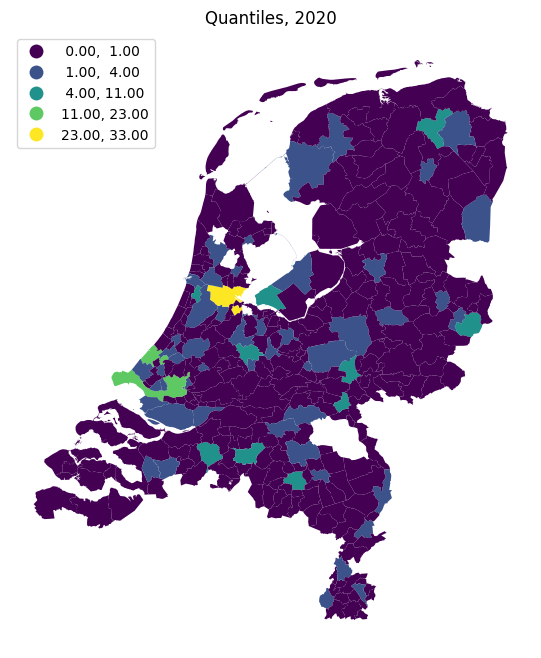

In [25]:
p = municipal_boundaries_nl.plot(column='Wert',
                             scheme="fisherjenks",
                             k=5,
                             legend=True,
                             legend_kwds={'loc': 'upper left'},
                             figsize = (8,8))
p.axis('off')
p.set_title('Quantiles, 2020')

Text(0.5, 1.0, 'Quantiles, 2020')

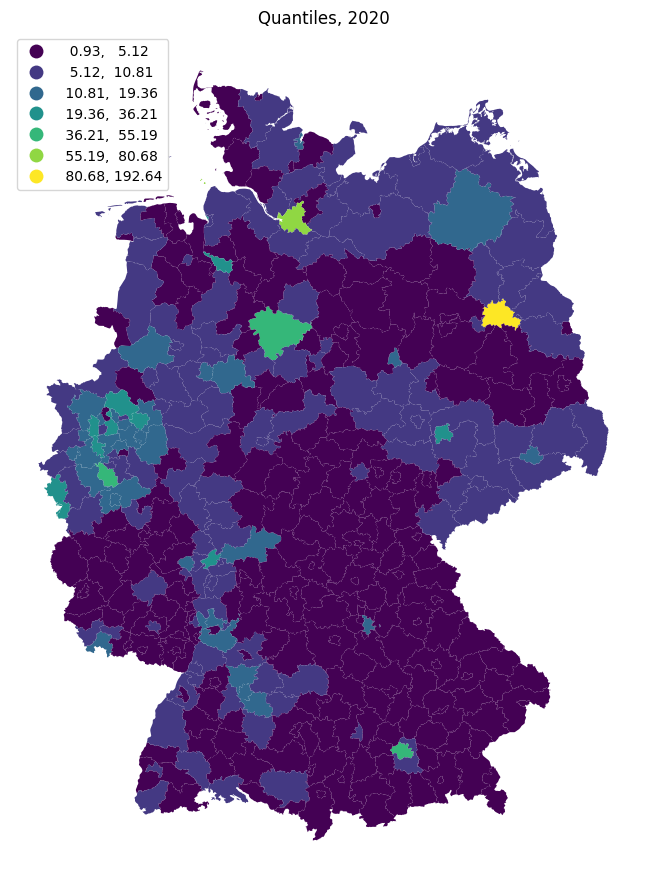

In [26]:
p = municipal_boundaries_de.plot(column='Wert',
                             scheme="fisherjenks",
                             k=7,
                             legend=True,
                             legend_kwds={'loc': 'upper left'},
                             figsize = (11,11))
p.axis('off')
p.set_title('Quantiles, 2020')

In [27]:
de = municipal_boundaries_de.to_crs('epsg:3035')
nl = municipal_boundaries_nl.to_crs('epsg:3035')

data_mixed = pd.concat([nl, de], ignore_index=True)

data_mixed


,Code,Name,geometry,Kennziffer,Wert,Zeitbezug
0,GM0014,Groningen,"MULTIPOLYGON (((4103810.729 3360893.031, 41039...",GM0014,9.000,2020
1,GM0034,Almere,"MULTIPOLYGON (((3999375.839 3268013.648, 39998...",GM0034,7.000,2020
2,GM0037,Stadskanaal,"MULTIPOLYGON (((4120663.331 3333600.459, 41208...",GM0037,1.000,2020
3,GM0047,Veendam,"MULTIPOLYGON (((4113524.608 3339956.737, 41158...",GM0047,1.000,2020
4,GM0050,Zeewolde,"MULTIPOLYGON (((4022614.611 3260017.421, 40225...",GM0050,1.000,2020
...,...,...,...,...,...,...
733,16073000,Saalfeld-Rudolstadt,"MULTIPOLYGON (((4409973.500 3080963.490, 44101...",16073000,3.111,2020
734,16074000,Saale-Holzland-Kreis,"MULTIPOLYGON (((4439969.466 3109415.347, 44399...",16074000,1.984,2020
735,16075000,Saale-Orla-Kreis,"MULTIPOLYGON (((4450032.187 3076981.042, 44500...",16075000,2.090,2020
736,16076000,Greiz,"MULTIPOLYGON (((4474946.993 3096997.500, 44751...",16076000,2.590,2020


Text(0.5, 1.0, 'Quantiles, 2020')

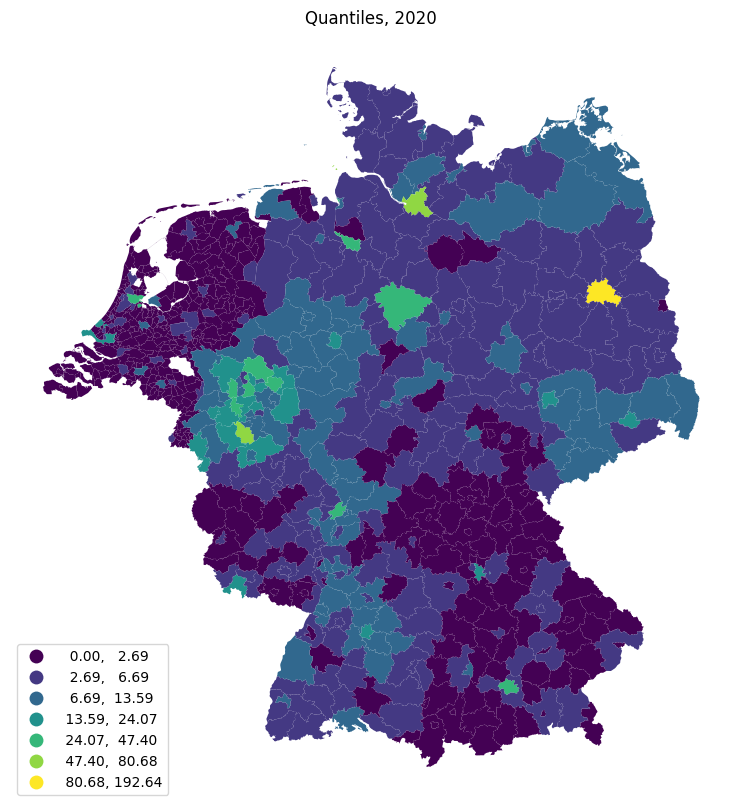

In [28]:
p = data_mixed.plot(column='Wert',
                             scheme="fisherjenks",
                             k=7,
                             legend=True,
                             legend_kwds={'loc': 'lower left'},
                             figsize = (10,10))
p.axis('off')
p.set_title('Quantiles, 2020')